# Radar Reflectivity Feature Detection and Classification
### Within this notebook, we will cover/review:
#### 1: How to create animated gifs with acquired radar data from Py-ART
#### 2: How to use the feature detection algorithm to compare against reflectivity

## Review the PPI GIF notebook to get yourself versed with making gifs in Py-ART, as much of the setup code will be similar

### Now that we know how to create animated gifs through use of basic python syntax and the Py-ART package, we will learn how to create GIFs of more obscure products such as feature detection.

#### If you would like to know more about how feature detection in Py-ART works and what exactly it does in detail, visit https://arm-doe.github.io/pyart/examples/retrieve/plot_convective_stratiform.html

# Prerequisites 


| Concepts | Importance | Notes |
| -------- | ---------- | ----- |
| [Quickstart: Zero to Python](https://foundations.projectpythia.org/foundations/quickstart.html) | Required | For loops, lists |
| [Matplotlib Basics](https://link-to-matplotlib-basics) | Required | Basic plotting |
| [Py-ART Basics](https://link-to-pyart-basics) | Required | IO/Visualization |
| [The Basics of Weather Radar](https://projectpythia.org/radar-cookbook/notebooks/radar-basics/radar-basics.html) | Required | Competency with Radar and its products |
| [Convective-Stratiform Classification](https://arm-doe.github.io/pyart/examples/retrieve/plot_convective_stratiform.html) | Required | Competency and understanding of the feature detection algorithm |


* **Time to learn:** 40 Minutes


# Imports for animated gif with Py-ART

In [10]:
import pyart
import fsspec
import matplotlib.pyplot as plt
import os
from io import BytesIO
import warnings
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
from PIL import Image
import numpy as np
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from IPython.display import display, Image as IPImage
%matplotlib inline

# Initializing AWS Filesystem

In [17]:
fs = fsspec.filesystem("s3", anon=True)

### We will use most of the same code for setting up the date selection, file grabbing, and station selection stuff as the PPI guide.

This will also create a directory to save the frames into

In [ ]:
start_date = datetime(2024, 6, 5, 4, 0)  # example start date
end_date = datetime(2024, 6, 5, 5, 0)    # example end date
station = 'KLOT'

# Generate the list of files for the specified date and hour range
files = []
current_time = start_date
while current_time <= end_date:
    date_str = current_time.strftime("%Y/%m/%d")
    datetime_str = current_time.strftime("%Y%m%d_%H")
    hour_str = current_time.strftime("%H")
    files += sorted(fs.glob(f"s3://noaa-nexrad-level2/{date_str}/{station}/{station}{datetime_str}*"))
    current_time += timedelta(hours=1)

# Print the selected files
print("Selected files:")
for file in files:
    print(file)

latitude = [41.700937896518866, 41.704120]
longitude = [-87.99578103231573, -87.968328]
labels = ['Tower', 'SCM']
markers = ['v', 'o']
colors = ['cyan', 'magenta']

def read_radar_data(file_path):
    try:
        with fs.open(file_path, 'rb') as f:
            radar_data = f.read()
        radar_file = BytesIO(radar_data)
        radar = pyart.io.read_nexrad_archive(radar_file)
        print(f"Successfully read radar data from {file_path}")
        return radar
    except Exception as e:
        print(f"Failed to read radar data from {file_path}: {e}")
        return None
frames_dir = 'frames/Feature'
os.makedirs(frames_dir, exist_ok=True)
frames = []

### The loop made to parse through the files is also similar, but we will instead set up our for loop to extract the scanning elevation in question, and interpolate it into a grid to use for the feature detection algorithm

Reflectivity will be used as a comparison to the algorithm. This can be changed by editing the field_name variable and selecting from the available fields listed previously.

Data is masked so that we dont see any areas with either no echo, or weak echoes, that would otherwise be denoted as 0 and 3 respectively.

The resolution of the frames are 300 dpi each, but this can be changed to higher or lower values (Higher DPI will create a more intensive load and will take longer to 
complete) 

If you would like to change the radar scanning elevation analyzed, you can change the index specified in "radar = radar.extract_sweeps([0])"

Other parameters such as colormaps and the extent shown on a figure can be changed to fit ones specific needs as well. 

In [ ]:
for i, file in enumerate(files):
    print(f"Processing file {i+1}/{len(files)}: {file}")
    # Read radar data
    radar = read_radar_data(file)
    if radar is None:
        print(f"Skipping file {file} due to read error.")
        continue

    # List available fields
    print(f"Available fields in radar data: {list(radar.fields.keys())}")

    # Use a suitable field name based on available fields
    field_name = "reflectivity"  # Use 'reflectivity' as the common field name

    # Extract the lowest sweep
    radar = radar.extract_sweeps([0])

    # Interpolate to grid
    grid = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(1, 201, 201),
        grid_limits=((0, 10000), (-50000.0, 50000.0), (-50000.0, 50000.0)),
        fields=[field_name],
    )

    # Get dx dy
    dx = grid.x["data"][1] - grid.x["data"][0]
    dy = grid.y["data"][1] - grid.y["data"][0]

    # Feature detection
    feature_dict = pyart.retrieve.feature_detection(
        grid,
        dx,
        dy,
        field=field_name,
        always_core_thres=40,
        bkg_rad_km=20,
        use_cosine=True,
        max_diff=5,
        zero_diff_cos_val=55,
        weak_echo_thres=10,
        max_rad_km=2,
    )

    # Add to grid object
    # Mask zero values (no surface echo)
    feature_masked = np.ma.masked_equal(feature_dict["feature_detection"]["data"], 0)
    # Mask 3 values (weak echo)
    feature_masked = np.ma.masked_equal(feature_masked, 3)
    # Add dimension to array to add to grid object
    feature_dict["feature_detection"]["data"] = feature_masked
    # Add field
    grid.add_field(
        "feature_detection", feature_dict["feature_detection"], replace_existing=True
    )

    # Create plot using GridMapDisplay
    # Plot variables
    display = pyart.graph.GridMapDisplay(grid)
    magma_r_cmap = plt.get_cmap("pyart_ChaseSpectral")
    ref_cmap = mcolors.LinearSegmentedColormap.from_list(
        "ref_cmap", magma_r_cmap(np.linspace(0, 0.9, magma_r_cmap.N))
    )
    projection = ccrs.AlbersEqualArea(
        central_latitude=radar.latitude["data"][0],
        central_longitude=radar.longitude["data"][0],
    )

    # Plot
    fig = plt.figure(figsize=[12, 4], dpi=300)
    ax1 = plt.subplot(1, 2, 1, projection=projection)
    display.plot_grid(
        field_name,
        vmin=9,
        vmax=65,
        cmap=ref_cmap,
        transform=ccrs.PlateCarree(),
        ax=ax1,
    )
    ax2 = plt.subplot(1, 2, 2, projection=projection)
    display.plot_grid(
        "feature_detection",
        vmin=0,
        vmax=2,
        cmap=plt.get_cmap("viridis", 3),
        ax=ax2,
        transform=ccrs.PlateCarree(),
        ticks=[1 / 3, 1, 5 / 3],
        ticklabs=["", "Stratiform", "Convective"],
    )

    # Set the extent to zoom out slightly
    ax1.set_extent([-88.3, -87.7, 41.5, 42.0], crs=ccrs.PlateCarree())
    ax2.set_extent([-88.3, -87.7, 41.5, 42.0], crs=ccrs.PlateCarree())

    # Add counties
    ax1.add_feature(USCOUNTIES, linewidth=0.5)
    ax2.add_feature(USCOUNTIES, linewidth=0.5)

    for lat, lon, label, marker, color in zip(latitude, longitude, labels, markers, colors):
        ax1.plot(lon, lat, marker, label=label, color=color, transform=ccrs.PlateCarree(), markersize=6)
        ax2.plot(lon, lat, marker, label=label, color=color, transform=ccrs.PlateCarree(), markersize=6)

    # Save the plot to a file
    filename = os.path.join(frame_dir, f'detection_frame_{i}.png')
    plt.tight_layout()
    plt.legend(loc='upper right', fontsize='large', title='Locations')
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)

    # Add the file to the frames list
    frames.append(filename)
    print(f"Saved frame {i+1}/{len(files)}: {filename}")

## GIF creation
The same method as the PPI is used to create a GIF out of the frames

In [24]:
if frames:
    print("Creating animated GIF...")
    images = [Image.open(frame) for frame in frames]
    gif_filename = 'feature_detection.gif'
    images[0].save(gif_filename, save_all=True, append_images=images[1:], duration=325, loop=0)  # duration in milliseconds

    # Clean up the saved frames
    for filename in frames:
        os.remove(filename)

    print("Animated GIF created as 'feature_detection.gif'")
    with open(gif_filename, 'rb') as f:
        display(IPImage(data=f.read(), format='gif'))
else:
    print("No frames were generated.")

No frames were generated.


# Entire code block

A more detailed explanation of the functions of each section of the code can be found on the PPI notebook, as this is set up nearly the same

### *NOTE that the commented print statements are meant for debugging and keeping track of the process. The breakdown of the code above keeps them uncommented, but for the sake of demonstration, I have commented them out to reduce space taken up

Animated GIF created as 'feature_detection.gif'


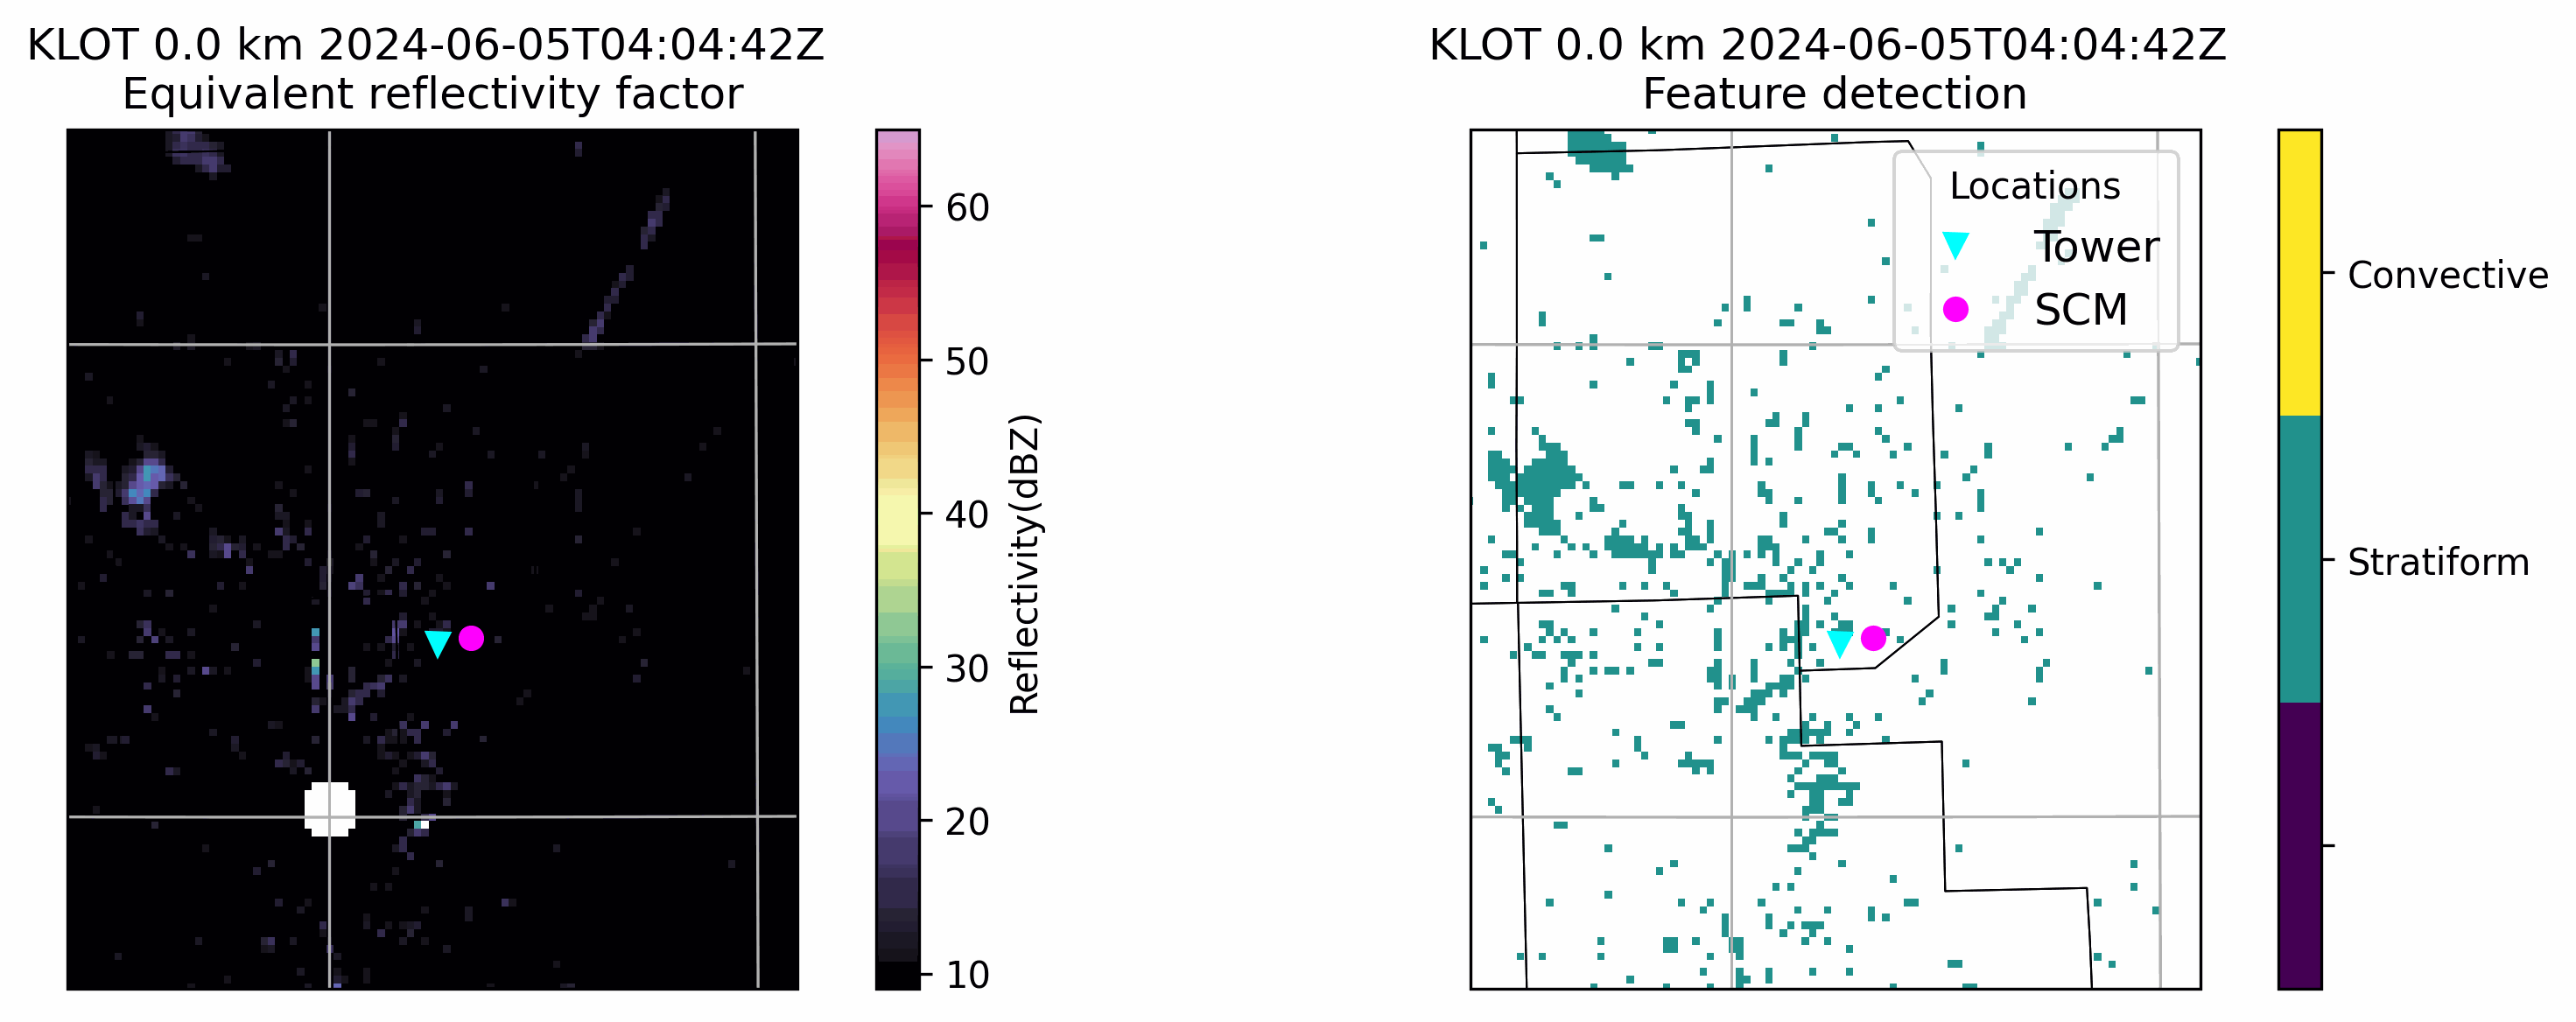

In [51]:
import pyart
import fsspec
import matplotlib.pyplot as plt
import os
from io import BytesIO
import warnings
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
from PIL import Image
import numpy as np
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from IPython.display import display, Image as IPImage
%matplotlib inline

warnings.filterwarnings("ignore")

# Setup the S3 filesystem
fs = fsspec.filesystem("s3", anon=True)

# Define the start and end dates and hours
start_date = datetime(2024, 6, 5, 4, 0)  # example start date
end_date = datetime(2024, 6, 5, 4, 0)    # example end date
station = 'KLOT'

# Generate the list of files for the specified date and hour range
files = []
current_time = start_date
while current_time <= end_date:
    date_str = current_time.strftime("%Y/%m/%d")
    datetime_str = current_time.strftime("%Y%m%d_%H")
    hour_str = current_time.strftime("%H")
    all_files = fs.glob(f"s3://noaa-nexrad-level2/{date_str}/{station}/{station}{datetime_str}*")
    filtered_files = [f for f in all_files if not f.endswith('_MDM')]
    files += sorted(filtered_files)
    current_time += timedelta(hours=1)

# Remove duplicates
files = list(dict.fromkeys(files))

# Print the selected files
#print("Selected files:")
#for file in files:
#print(file)

latitude = [41.700937896518866, 41.704120]
longitude = [-87.99578103231573, -87.968328]
labels = ['Tower', 'SCM']
markers = ['v', 'o']
colors = ['cyan', 'magenta']

def read_radar_data(file_path):
    try:
        with fs.open(file_path, 'rb') as f:
            radar_data = f.read()
        radar_file = BytesIO(radar_data)
        radar = pyart.io.read_nexrad_archive(radar_file)
        #print(f"Successfully read radar data from {file_path}")
        return radar
    except Exception as e:
        print(f"Failed to read radar data from {file_path}: {e}")
        return None

frames_dir = 'frames/Feature'
os.makedirs(frames_dir, exist_ok=True)
frames = []
for i, file in enumerate(files):
    #print(f"Processing file {i+1}/{len(files)}: {file}")
    # Read radar data
    radar = read_radar_data(file)
    if radar is None:
        print(f"Skipping file {file} due to read error.")
        continue

    # List available fields
    #print(f"Available fields in radar data: {list(radar.fields.keys())}")

    # Use a suitable field name based on available fields
    field_name = "reflectivity"  # Use 'reflectivity' as the common field name

    # Extract the lowest sweep
    radar = radar.extract_sweeps([0])

    # Interpolate to grid
    grid = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(1, 201, 201),
        grid_limits=((0, 10000), (-50000.0, 50000.0), (-50000.0, 50000.0)),
        fields=[field_name],
    )

    # Get dx dy
    dx = grid.x["data"][1] - grid.x["data"][0]
    dy = grid.y["data"][1] - grid.y["data"][0]

    # Feature detection
    feature_dict = pyart.retrieve.feature_detection(
        grid,
        dx,
        dy,
        field=field_name,
        always_core_thres=40,
        bkg_rad_km=20,
        use_cosine=True,
        max_diff=5,
        zero_diff_cos_val=55,
        weak_echo_thres=10,
        max_rad_km=2,
    )

    # Add to grid object
    # Mask zero values (no surface echo)
    feature_masked = np.ma.masked_equal(feature_dict["feature_detection"]["data"], 0)
    # Mask 3 values (weak echo)
    feature_masked = np.ma.masked_equal(feature_masked, 3)
    # Add dimension to array to add to grid object
    feature_dict["feature_detection"]["data"] = feature_masked
    # Add field
    grid.add_field(
        "feature_detection", feature_dict["feature_detection"], replace_existing=True
    )

    # Create plot using GridMapDisplay
    # Plot variables
    grid_display = pyart.graph.GridMapDisplay(grid)
    magma_r_cmap = plt.get_cmap("pyart_ChaseSpectral")
    ref_cmap = mcolors.LinearSegmentedColormap.from_list(
        "ref_cmap", magma_r_cmap(np.linspace(0, 0.9, magma_r_cmap.N))
    )
    projection = ccrs.AlbersEqualArea(
        central_latitude=radar.latitude["data"][0],
        central_longitude=radar.longitude["data"][0],
    )

    # Plot
    fig = plt.figure(figsize=[12, 4], dpi=300)
    ax1 = plt.subplot(1, 2, 1, projection=projection)
    grid_display.plot_grid(
        field_name,
        vmin=9,
        vmax=65,
        cmap=ref_cmap,
        transform=ccrs.PlateCarree(),
        ax=ax1,
    )
    ax2 = plt.subplot(1, 2, 2, projection=projection)
    grid_display.plot_grid(
        "feature_detection",
        vmin=0,
        vmax=2,
        cmap=plt.get_cmap("viridis", 3),
        ax=ax2,
        transform=ccrs.PlateCarree(),
        ticks=[1 / 3, 1, 5 / 3],
        ticklabs=["", "Stratiform", "Convective"],
    )

    # Set the extent to zoom out slightly
    ax1.set_extent([-88.3, -87.7, 41.5, 42.0], crs=ccrs.PlateCarree())
    ax2.set_extent([-88.3, -87.7, 41.5, 42.0], crs=ccrs.PlateCarree())

    # Add counties
    ax1.add_feature(USCOUNTIES, linewidth=0.5)
    ax2.add_feature(USCOUNTIES, linewidth=0.5)

    for lat, lon, label, marker, color in zip(latitude, longitude, labels, markers, colors):
        ax1.plot(lon, lat, marker, label=label, color=color, transform=ccrs.PlateCarree(), markersize=6)
        ax2.plot(lon, lat, marker, label=label, color=color, transform=ccrs.PlateCarree(), markersize=6)

    # Save the plot to a file
    filename = os.path.join(frames_dir, f'detection_frame_{i}.png')
    plt.tight_layout()
    plt.legend(loc='upper right', fontsize='large', title='Locations')
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)

    # Add the file to the frames list
    frames.append(filename)
    #print(f"Saved frame {i+1}/{len(files)}: {filename}")

# Create an animated GIF using Pillow
if frames:
    #print("Creating animated GIF...")
    images = [Image.open(frame) for frame in frames]
    gif_filename = 'feature_detection.gif'
    images[0].save(gif_filename, save_all=True, append_images=images[1:], duration=325, loop=0)  # duration in milliseconds

    # Clean up the saved frames
    for filename in frames:
        os.remove(filename)

    print("Animated GIF created as 'feature_detection.gif'")
    
    with open(gif_filename, 'rb') as f:
        display(IPImage(data=f.read(), format='gif'))
else:
    print("No frames were generated.")


# Summary

Continuing with animated GIF making in Py-ART, we have went over how make a dual panel figure showing both reflectivity and feature detection using basic python syntax, Py-ART, and NEXRAD level 2 data.

## What comes next?

#### Continuing the saga, a guide on how to make vertical columns and complex plots with Py-ART will follow. Make sure to look over this and the previous PPI GIF guide to better understand 